# Portfolio Optimization by Shaping the Empirical Return Distribution

## Contents
1. Introduction
2. Mathematical problem statement
3. Implementation
4. Numerical example
5. Conclusion and directions for future work (scalability/parallel implementation)

## 1. Introduction
In this notebook, we present a portfolio optimization technique that seeks to maximize the expected return while accounting for a finite number of constraints related to limits of the value at risk (VaR) at one or several significance levels. We will show that this formulation makes it possible to view portfolio optimization as maximizing the mean of a distibution, that is linearly parametrized by the portfolio weights, subject to keeping the left/negative tail of the distribution below a user-defined distribution, which we will refer to as the _risk profile_. We will then bring this problem to into the form of a mixed-integer linear programming (MILP) problem and demonstrate its efficacy on a simple numerical example. Finally, we conclude and show some directions for future work.

## 2. Mathematical problem statement
Let $x \in \mathbb{R}^d, d \in \mathbb{N}$ denote a random variable describing the returns of $d$ assets. Let $D:=\{1,2,\dots,d\}$ and let $w\in W:=[0,1]^d$, such that $\sum_{i\in D} w_i = 1$, denote the weights of the assets in the portfolio. Then the (random) portfolio return is $\mathbb{E}[x]^\top w$, where $\mathbb{E}[\cdot]$ denotes the (element-wise) expectation operator associated with the distribution of each of the $d$ assets.

Since the exact expectation is unavailable in practice, we replace $\mathbb{E}[x]$ in the expression above by $\bar{x}\in \mathbb{R}^d$, which denotes the empirical mean return of $x$ from $n\in \mathbb{N}$ observations $x^{(n)}$, i.e. $\bar{x}_i = \frac{1}{n}\sum_n x_i^{(n)}$. Hence, our maximisation objective becomes 
\begin{equation}
\underset{w\in W}{\max}\bar{x}^\top w,
\end{equation}
which is linear in $w$. Let us now focus on the additional constraints that we seek to enforce. To this end, define two vector-valued parameters, $A\in [0,1]^k$ and $V\in\mathbb{R}^k$, where $k\in \mathbb{N}$. These are significance levels and corresponding values at risk. For example $A:=[0.01,0.05]$ and $V:=[-0.2,-0.1]$ would denote two VaR constraints, i.e. the 1% value at risk should be no smaller than -20% and the 5% value at risk should be no smaller than -10%. The constraints are then formulated, using an additional auxiliary variable $z^{(a)}\in [0,1]^n$ for all $a \in K:=\{1,2,\dots,k\}$, as

\begin{align}
\sum_{i\in N} z^{(a)}_i =& n A_a \text{, for all } a \in K,\\
x_i^\top w \geq& V_a - M(1-z^{(a)}_i) \text{, for all } (a,i) \in K\times N,
\end{align}

where $M\in \mathbb{R}_++$ is sufficiently large, such that the inequality is always satisfied when $z^{(a)}_i=1$, for all choices of $w\in W$. Hence, this reformulation is also known as the big $M$ method. The first equality constraint ensures that for any VaR condition $a\in K$, the number of $z^{(a)}_i=1$ equal the fraction of samples $n$, i.e. $z^{(a)}$ is a selector variable that ensures that sufficiently many constraints need to be satisfied, i.e. if $z^{(a)}_i =1$, then the weights $w$ must be chosen such that $x_i^\top w \geq V_a$. This ensures that the VaR constraint is satisfied. Combining the objective and the constraints, we are now ready to implement this problem in Python.

## 3. Imlementation
We use Pyhon and the $\texttt{mip}$ package (https://www.python-mip.com/) for mixed-integer linear programming and formulat the optimization routine by means of the following function:

In [1]:
def portfolioMILP(X, alpha=[0.05], VaR=[0], M = 2, max_weight=1, max_s = 10, abs_gap=1e-3):
    """
    Optimizes portfolio weights in a Mixed-Integer Linear Programming (MILP) setting, based on data X with n rows (observations)
    and d columns (assets), given a list (even if only a single value is desired!) of values at risk (VaR) at significance levels alpha, respectively. The variable
    "M" is used in a big M method trick to linearise the constraints. "max_weights" defines the maximum weight of an asset,
    "max_s" defines the maximum computation time, "abs_gap" defines the absolute gap between upper bound and lower bound on the solution,
    upon which the algorithm shall terminate.
    """
    
    n,d = X.shape
    X_mean = X.mean(axis=0)
    print(f"Optimizing over {d} assets using {n} samples")
    
    n_alpha = len(alpha)
    V=[[] for i in range(n_alpha)]
    
    m = Model(solver_name=CBC)
    m.max_mip_gap_abs = abs_gap
    
    w = [ m.add_var(var_type=CONTINUOUS) for dd in range(d) ] #decision variables (asset weights)
    m.objective = minimize(-xsum(w[dd]*X_mean[dd] for dd in range(d))) #objective function
    m += xsum(w[dd] for dd in range(d)) == 1 #asset weights sum to 1
    
    #VaR constraints
    for aa in range(n_alpha): #for all VaR constraints
        n_activeCon = np.ceil(n*(1-alpha[aa])) #number of constraints that need to be active at solution
        
        v = [] #indices of violation samples (samples for which a feasible w exists that would violate the VaR constraint)
        for i in range(n):
            if any(X[i,:] < VaR[aa]): #else, no weights w lead to a return of sample i to be less than the VaR
                v.append(i)
        n_v = len(v) 
        V[aa] = v #useful for visualising the solution

        z = [m.add_var(name=f"z_{aa}_{vv}",var_type=BINARY) for vv in range(n_v) ] #selector variable for active constraints
        m += xsum(m.var_by_name(f'z_{aa}_{vv}') for vv in range(n_v)) == max(0,n_activeCon - (n-n_v)) #n-n_v constraints always satisfied
        for vv in range(n_v):
            m += xsum(w[dd]*X[v[vv],dd] for dd in range(d)) >= (VaR[aa] - (1-m.var_by_name(f'z_{aa}_{vv}'))*M) #linearized VaR constraint using bigg M notation
    
    #weight constraints
    if type(max_weight) != list and max_weight != 1: 
        for dd in range(d):
            m += w[dd] <= max_weight
    else:
        for dd in range(d):
            m += w[dd] <= max_weight[dd]

    #obtain model summary
    m.write('model.lp')
    m.read('model.lp')
    print('The model has {} vars, {} constraints and {} nzs'.format(m.num_cols, m.num_rows, m.num_nz))

    # optimizing
    status = m.optimize(max_seconds = max_s)
    if status != OptimizationStatus.OPTIMAL:
        print(np.round(alpha,3), np.round(VaR,3), status) #if solution not optimal, print details
    return m,V

## 4. Numerical Example

We now consider a simple 2-dimensional example ($d=2$), where the two assets are the S&P 500 index ("gspc") and the gold price ("gold"). For the purpose of this simple example we ignore any other costs related to the investment or its liquidation (e.g. taxes). We use the following helper function to 
* extract the data from ".csv"-files,
* fill in missing values for days without trade (e.g. weekends),
* to select the common period for all assets
* and to store the results in a pandas data frame.

In [227]:
def loadData(files, days):
    """
    Reads csv "files", fills in missing dates and close prices, computes annualized returns over the number of "days" and returns a pandas 
    data frame.
    """
    years=1#days/365 #used to compute annualized returns
    dataFrames_in = []
    start_dates = [] 
    end_dates =[] #used to find greatest common trade period
    
    for file in files:
        df_in = pd.read_csv('C:/Users/worc3920/Documents/GitHub/EmpiricalPortfolio/data/'+file+'.csv', usecols=["Date","Close"]) #file path may depend on your project
        df_in = df_in.rename(columns={"Close": "Close_" + file})
        df_in["Date"]=pd.to_datetime(df_in["Date"], infer_datetime_format=True)
        dataFrames_in.append(df_in)
        start_dates.append(df_in.loc[0,"Date"])
        end_dates.append(df_in.loc[df_in.index[-1],"Date"])
    
    df_start = max(start_dates) #select latest common start date
    df_end = min(end_dates) #select earliest common end date, hence data available for all selected dates and assets
    df = pd.DataFrame()
    df["Date"] = pd.date_range(start=df_start, end=df_end)

    for i in range(len(files)):
        df = df.merge(dataFrames_in[i], on='Date', how='inner') #combine data frames, "inner" to avoid nan values
    
    df = df.dropna()
    df = df.reset_index(drop=True)
    for file in files:
        #Ensure no NaN values at the beginning of the data set
        #j=0
        #while True:
        #    if np.isnan(df.loc[j,"Close_" + file]):
        #        j += 1
        #    else:
        #        df.loc[0:j-1,"Close_" + file] = df.loc[j,"Close_" + file]
        #        break
        #Replace NaN values by previous (valid) value
        #for i in range(0,len(df)):
        #    if np.isnan(df.loc[i,"Close_" + file]):
        #        df.loc[i, "Close_" + file] = df.loc[i-1, "Close_"+file]
        
        #Compute return, assuming that negative final values will be replaced by 0
        for i in range(len(df)-days):
            #df.loc[i, "Return_" + file] = np.log((np.max([0,df.loc[i+days, "Close_"+file]])/df.loc[i, "Close_"+file])**(1/years)) #log annual return
            df.loc[i, "Return_" + file] = np.log(np.max([0,df.loc[i+days, "Close_"+file]])/df.loc[i, "Close_"+file]) #log daily return
    #drop last days entries, for which no return could be computed
    return df.drop(columns=["Close_" + file for file in files]).iloc[:-days-1]

Let us begin by loading all required packages and obtaining the data using the above helper function:

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import pandas as pd
import datetime
import warnings
from mip import *
import time

#read data and show summary
#files = ["gspc","gold","n225","hsi","oil"]
files = ["gspc","hsi"]
days=253#365 #a year without weekends and holidays
df = loadData(files, days)
#df = df.dropna()
fileR = ["Return_" + file for file in files]

In [238]:
df["equal_split"]=(df[fileR].sum(axis=1))/len(files)
print(np.round(df.describe(),2))

np.isnan(df).sum()
df["Date"].describe(datetime_is_numeric=True)

       Return_gspc  Return_hsi  equal_split
count      7950.00     7950.00      7950.00
mean          0.08        0.07         0.07
std           0.16        0.25         0.18
min          -0.72       -0.94        -0.83
25%           0.03       -0.08        -0.02
50%           0.10        0.10         0.11
75%           0.18        0.23         0.18
max           0.55        0.85         0.58


count                             7950
mean     2003-06-16 22:13:40.528301952
min                1986-12-31 00:00:00
25%                1995-03-10 18:00:00
50%                2003-06-14 12:00:00
75%                2011-09-14 18:00:00
max                2019-12-31 00:00:00
Name: Date, dtype: object

In [7]:
percentiles = [0.001,0.01]#,0.05]
n_df = len(df)
myVaR = np.sort(df["equal_split"].to_numpy())[[int(np.round(n_df*percentiles[i])) for i in range(len(percentiles))]]
print(np.array(percentiles)*100) #percentiles in percent
print(np.round(myVaR*100,2)) #VaR in percent

[0.1 1. ]
[-7.28 -2.96]


In [8]:
df[fileR].corr()

,Return_gspc,Return_hsi
Return_gspc,1.000000,0.200313
Return_hsi,0.200313,1.000000


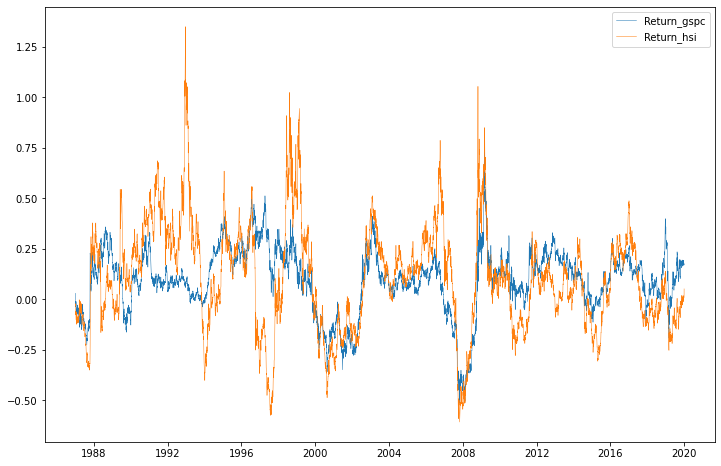

In [239]:
epsilon=10**(-3)
fileR_e = fileR.copy()
fileR_e.append("equal_split")
fig, ax = plt.subplots(figsize=(12, 8))
#ax.plot(df["Date"], np.log(df["Return_gspc"]+1+epsilon), linewidth=0.1)
ax.plot(df["Date"], np.exp(df[fileR])-1, linewidth=0.5, alpha=1)
ax.legend(fileR_e);
#ax.set_ylim((-10,10))
#ax.set_xlim((0,1000))

Notice that an equal allocation to both assets would result in a mean between the means of the individual assets, but the standard error (std) is smaller.

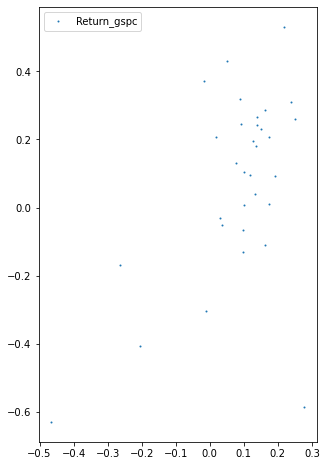

In [240]:
X = df[fileR].to_numpy()
X00 = X[[X[i,0]!=0 and X[i,1] !=0 for i in range(len(X))],:]
fig, ax = plt.subplots(figsize=(8, 8))
epsilon=10**(-3)
plt.scatter(X[::days,0],X[::days,1],s=1)
ax.legend(fileR_e);
#ax.set_ylim((-0.05,0.05))
#ax.set_xlim((-0.05,0.05))
plt.gca().set_aspect('equal', adjustable='box')

In [114]:
from scipy.optimize import minimize
import numpy as np
from scipy.special import gamma


class mgarch:
    
    def __init__(self, dist = 'norm'):
        if dist == 'norm' or dist == 't':
            self.dist = dist
        else: 
            print("Takes pdf name as param: 'norm' or 't'.")
            
    def garch_fit(self, returns):
        res = minimize( self.garch_loglike, (0.01, 0.01, 0.94), args = returns,
              bounds = ((1e-6, 1), (1e-6, 1), (1e-6, 1)))
        return res.x

    def garch_loglike(self, params, returns):
        T = len(returns)
        var_t = self.garch_var(params, returns)
        LogL = np.sum(-np.log(2*np.pi*var_t)) - np.sum( (returns.A1**2)/(2*var_t))
        return -LogL

    def garch_var(self, params, returns):
        T = len(returns)
        omega = params[0]
        alpha = params[1]
        beta = params[2]
        var_t = np.zeros(T)     
        for i in range(T):
            if i==0:
                var_t[i] = returns[i]**2
            else: 
                var_t[i] = omega + alpha*(returns[i-1]**2) + beta*var_t[i-1]
        return var_t        
        
    def mgarch_loglike(self, params, D_t):
        # No of assets
        a = params[0]
        b = params[1]
        Q_bar = np.cov(self.rt.reshape(self.N, self.T))

        Q_t = np.zeros((self.T,self.N,self.N))
        R_t = np.zeros((self.T,self.N,self.N))
        H_t = np.zeros((self.T,self.N,self.N))
        
        Q_t[0] = np.matmul(self.rt[0].T/2, self.rt[0]/2)

        loglike = 0
        for i in range(1,self.T):
            dts = np.diag(D_t[i])
            dtinv = np.linalg.inv(dts)
            et = dtinv*self.rt[i].T
            Q_t[i] = (1-a-b)*Q_bar + a*(et*et.T) + b*Q_t[i-1]
            qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

            R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))


            H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))   

            loglike = loglike + self.N*np.log(2*np.pi) + \
                      2*np.log(D_t[i].sum()) + \
                      np.log(np.linalg.det(R_t[i])) + \
                      np.matmul(self.rt[i], (np.matmul( np.linalg.inv(H_t[i]), self.rt[i].T)))


        return float(loglike)

    
    def mgarch_logliket(self, params, D_t):
        # No of assets
        a = params[0]
        b = params[1]
        dof = params[2]
        Q_bar = np.cov(self.rt.reshape(self.N, self.T))

        Q_t = np.zeros((self.T,self.N,self.N))
        R_t = np.zeros((self.T,self.N,self.N))
        H_t = np.zeros((self.T,self.N,self.N))
        
        Q_t[0] = np.matmul(self.rt[0].T/2, self.rt[0]/2)

        loglike = 0
        for i in range(1,self.T):
            dts = np.diag(D_t[i])
            dtinv = np.linalg.inv(dts)
            et = dtinv*self.rt[i].T
            Q_t[i] = (1-a-b)*Q_bar + a*(et*et.T) + b*Q_t[i-1]
            qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

            R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))


            H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))   

            loglike = loglike + np.log( gamma((self.N+dof)/2.)) - np.log(gamma(dof/2)) \
                      -(self.N/2.)*np.log(np.pi*(dof - 2)) - np.log(np.linalg.det(H_t[i])) \
- ((dof+ self.N)*( ((np.matmul(self.rt[i], (np.matmul( np.linalg.inv(H_t[i]), self.rt[i].T))))/(dof - 2.)) + 1)/2.)

        return -loglike
    
    
    def predict(self, new_rt, ndays = 1, justH=True):
        if 'a' in dir(self):
            self.rt = np.matrix(new_rt)
            self.T, self.N = self.rt.shape
            Q_bar = np.cov(self.rt.reshape(self.N, self.T))

            Q_t = np.zeros((self.T,self.N,self.N)) #??
            R_t = np.zeros((self.T,self.N,self.N)) #matrix of conditional correlations
            H_t = np.zeros((self.T,self.N,self.N)) #conditional covariance matrix

            Q_t[0] = np.matmul(self.rt[0].T/2, self.rt[0]/2)

            loglike = 0
            
            if len(self.D_t) < self.T:
                D_t = np.zeros((self.T, self.N))
                for i in range(self.N):
                    params = self.params[i]
                    D_t[:,i] = np.sqrt(self.garch_var(params, self.rt[:,i]))
                self.D_t = D_t
            
            for i in range(1,self.T):
                dts = np.diag(self.D_t[i])  #diagonal matrix of conditional variances
                dtinv = np.linalg.inv(dts)  #its inverse
                et = dtinv*self.rt[i].T     #conditional errors?
                Q_t[i] = (1-self.a-self.b)*Q_bar + self.a*(et*et.T) + self.b*Q_t[i-1]
                qts = np.linalg.inv(np.sqrt(np.diag(np.diag(Q_t[i]))))

                R_t[i] = np.matmul(qts, np.matmul(Q_t[i], qts))


                H_t[i] = np.matmul(dts, np.matmul(R_t[i], dts))  

            ##########additional attributes
            self.H_t = H_t
            if justH == True:
                return H_t[-1]
            if self.dist == 'norm':
                return {'dist': self.dist, 'cov': H_t[-1]*np.sqrt(ndays)}
            elif self.dist == 't':
                return {'dist': self.dist, 'dof': self.dof, 'cov': H_t[-1]*np.sqrt(ndays)}
            
        else:
            print('Model not fit')
            
            
    def fit(self, returns):
        self.rt = np.matrix(returns)
        
        self.T = self.rt.shape[0]
        self.N = self.rt.shape[1]
        
        if self.N == 1 or self.T == 1:
            return 'Required: 2d-array with columns > 2' 
        self.mean = self.rt.mean(axis = 0)
        self.rt = self.rt - self.mean
        
        D_t = np.zeros((self.T, self.N))
        params=[]
        for i in range(self.N):
            params.append(self.garch_fit(self.rt[:,i]))
            D_t[:,i] = np.sqrt(self.garch_var(params[-1], self.rt[:,i]))
        self.D_t = D_t
        self.params = params
        
        if self.dist == 'norm':
            res = minimize(self.mgarch_loglike, (0.01, 0.94), 
                           args = D_t, bounds = ((1e-6, 1), (1e-6, 1)))#,options = {'maxiter':10000000, 'disp':True})
            self.a = res.x[0]
            self.b = res.x[1]
            
            return {'mu': self.mean, 'alpha': self.a, 'beta': self.b} 
        elif self.dist == 't':
            res = minimize(self.mgarch_logliket, (0.01, 0.94, 3), args = D_t,
            bounds = ((1e-6, 1), (1e-6, 1), (3, None)), 
            #options = {'maxiter':10000000, 'disp':True},
            )
            self.a = res.x[0]
            self.b = res.x[1]
            self.dof = res.x[2]
            return {'mu': self.mean, 'alpha': self.a, 'beta': self.b, 'dof': self.dof}

In [29]:
#rt=res.resid
rt = res.resid
dist="norm"
vol = mgarch(dist)
res2 = vol.fit(rt)


In [228]:
test1= np.random.rand(5,3)
np.r_[test1,test1]

array([[0.14938335, 0.76145763, 0.51047246],
       [0.90237394, 0.58181169, 0.48036104],
       [0.23925993, 0.3117919 , 0.37789688],
       [0.65409024, 0.92846466, 0.89080021],
       [0.34187885, 0.55042548, 0.68664057],
       [0.14938335, 0.76145763, 0.51047246],
       [0.90237394, 0.58181169, 0.48036104],
       [0.23925993, 0.3117919 , 0.37789688],
       [0.65409024, 0.92846466, 0.89080021],
       [0.34187885, 0.55042548, 0.68664057]])

In [218]:
#print(vol.predict())
#print(res.predict(start=vol.T+1, end=vol.T+1))
print(len(X_exp))

22


In [261]:
from scipy.optimize import minimize
print(days)
X_exp = X[::days,:] #experiment data (every 30 days)
#X_exp[:,[0,1]] = X_exp[:,[1,0]]
pred_horizon = 5 #predict 1 year ahead (12 months in a year)

import statsmodels.api as sm
#fit VARMA model
myp=1
myq=2
mod = sm.tsa.VARMAX(X_exp, order=(myp,myq))
res_varma = mod.fit(maxiter=100, disp=True)
print("VARMA model fitted.")

rt_w_pred = res_varma.resid #returns with predictions holder, given by the residuals of the VARMA model

#fit GARCH model with available data
dcc = mgarch('norm')
res_dcc = dcc.fit(rt_w_pred)
print("DCC-GARCH model fitted.")

#obtain standardized residual errors
dcc.predict(new_rt = rt_w_pred) #to obtain H_t
H_t_half_inv = np.zeros((dcc.T,dcc.N,dcc.N))
for tt in range(1,dcc.T):
    H_t_half_inv[tt,:,:] = inv(cholesky(dcc.H_t[tt,:,:]))

z = np.zeros((dcc.T,dcc.N))
for tt in range(dcc.T):
    z[tt,:] = H_t_half_inv[tt,:,:] @ (rt_w_pred[tt,:]-np.array(dcc.mean).reshape(dcc.N,))

print("z obtained.")

n_samples = 100
predictions = np.zeros((pred_horizon, dcc.N, n_samples)) #pred horizon x assets x samples
for nn in range(n_samples):
    print(f"Predicting sample {nn+1} out of {n_samples}.")
    
    #random residual choices
    random_indices = np.random.choice(a=len(z), size=pred_horizon, replace=True)
    rand_z = z[random_indices,:]
    
    #bootstrapped prediction
    predictions[:,:,nn] = sample_pred(rt, rand_z, pred_horizon, res_varma, dcc)

print("Done.")

253


C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in log


VARMA model fitted.
DCC-GARCH model fitted.
z obtained.
Predicting sample 1 out of 100.
Predicting sample 2 out of 100.
Predicting sample 3 out of 100.
Predicting sample 4 out of 100.
Predicting sample 5 out of 100.
Predicting sample 6 out of 100.
Predicting sample 7 out of 100.
Predicting sample 8 out of 100.
Predicting sample 9 out of 100.
Predicting sample 10 out of 100.
Predicting sample 11 out of 100.
Predicting sample 12 out of 100.
Predicting sample 13 out of 100.
Predicting sample 14 out of 100.
Predicting sample 15 out of 100.
Predicting sample 16 out of 100.
Predicting sample 17 out of 100.
Predicting sample 18 out of 100.
Predicting sample 19 out of 100.
Predicting sample 20 out of 100.
Predicting sample 21 out of 100.
Predicting sample 22 out of 100.
Predicting sample 23 out of 100.
Predicting sample 24 out of 100.
Predicting sample 25 out of 100.
Predicting sample 26 out of 100.
Predicting sample 27 out of 100.
Predicting sample 28 out of 100.
Predicting sample 29 out of 1

0.5338343261575162
3.434741786757551


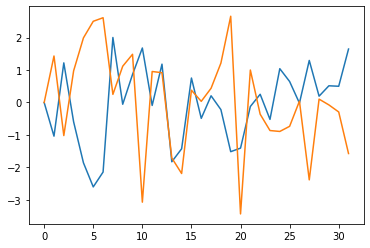

In [262]:
#plt.scatter(x=X_exp[:,0],y=X_exp[:,1])
#plt.scatter(x=predictions[-1,0,:],y=predictions[-1,1,:]);
print(np.max(np.abs(res_varma.resid)))
print(np.max(np.abs(z)))
plt.plot(z)

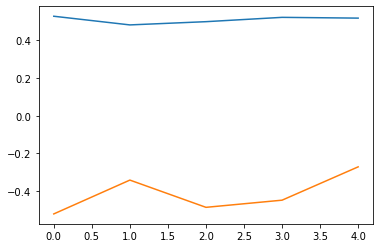

In [265]:
asset=1

plt.plot(np.max(predictions[:,asset,:], axis=-1))
#plt.plot(np.mean(predictions[:,asset,:],axis=-1)+1.96*np.std(predictions[:,asset,:],axis=-1))
#plt.plot(np.mean(predictions[:,asset,:],axis=-1)-1.96*np.std(predictions[:,asset,:],axis=-1))
plt.plot(np.min(predictions[:,asset,:], axis=-1))
#plt.yscale('log')

2.658806982980679 -3.434741786757551
0.4383958122139062 -0.5338343261575162
[[ 0.          0.        ]
 [-1.03764016  1.43310038]
 [ 1.22105409 -1.01952437]
 [-0.59582627  0.97579541]
 [-1.85874497  1.99151311]
 [-2.60181687  2.50312544]
 [-2.14411458  2.61311783]
 [ 2.00382094  0.25004333]
 [-0.05403996  1.11797057]
 [ 0.86384108  1.48594737]
 [ 1.67987619 -3.07252094]
 [-0.09074529  0.95531086]
 [ 1.18182611  0.91891223]
 [-1.82719513 -1.71040671]
 [-1.42671247 -2.18900483]
 [ 0.75408444  0.37764986]
 [-0.48907419  0.03560694]
 [ 0.20688959  0.43899399]
 [-0.21970159  1.21391833]
 [-1.51599889  2.65880698]
 [-1.40629004 -3.43474179]
 [-0.12315126  1.00103475]
 [ 0.25338231 -0.3612777 ]
 [-0.52062666 -0.86454679]
 [ 1.04221489 -0.89266308]
 [ 0.64671599 -0.73442605]
 [-0.01904972  0.0405819 ]
 [ 1.29630104 -2.38488131]
 [ 0.19483255  0.10400276]
 [ 0.51505575 -0.07457977]
 [ 0.50034349 -0.29215009]
 [ 1.64779541 -1.57327531]]


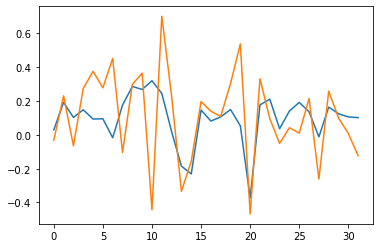

In [264]:
print(np.max(z),np.min(z))
print(np.max(res_varma.resid),np.min(res_varma.resid))

print(z)
plt.plot(np.exp(X_exp)-1)

5
[[ 1.65932397e-01  1.30084174e-01]
 [ 2.15441798e-01  2.17646050e-02]
 [ 3.55325402e-02  6.57661094e-02]
 [ 1.39466173e-01  1.69130709e-01]
 [ 1.60461765e-01  1.06286734e-01]
 [ 3.83825710e-02  1.89286068e-02]
 [-5.11995373e-02  3.01836541e-02]
 [-8.32674909e-03  8.16898834e-02]
 [ 4.97291000e-02  1.63990113e-01]
 [ 5.70772358e-02  6.42983438e-02]
 [ 1.16198306e-01  1.93513081e-01]
 [ 1.21520771e-01  9.65085389e-02]
 [-2.31842932e-02 -6.23576393e-05]
 [ 4.92494335e-02  1.41874944e-02]
 [ 4.63704577e-02  8.34782535e-02]
 [ 6.27711389e-02  1.18362046e-01]
 [ 6.16755537e-02  8.41269471e-02]
 [ 2.15846854e-01  1.38446667e-01]
 [ 1.35938289e-04  1.54727930e-01]
 [ 1.40271249e-01  1.25865054e-01]
 [ 2.38265733e-01  1.85271450e-01]
 [ 1.55058594e-01  1.38503083e-01]
 [-9.39821183e-02  3.15607074e-03]
 [-1.92779892e-02  5.25441740e-02]
 [ 6.53629767e-02 -7.78786365e-02]
 [ 1.06532899e-01  8.38887312e-02]
 [ 1.64088136e-01  1.68292689e-01]
 [-9.98433209e-02  3.46423461e-02]
 [-6.61850726e-02 

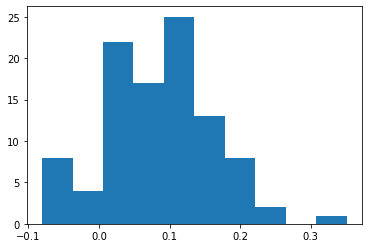

In [268]:
#Predicted "un-logged" cumulative returns calculation:
print(pred_horizon)
pred_returns = np.sum(predictions, axis = 0) # d x n_samples
pred_returns = ((np.exp(pred_returns)**(1/pred_horizon)-1)).T #remove logs, convert to "standard" returns, transposed ##ASSUMING A HORIZON IN YEARS!!!!

plt.hist(pred_returns[:,1],bins=10);
print(pred_returns)

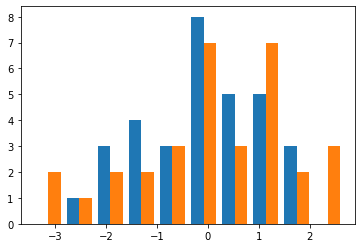

In [259]:
plt.hist(z);

In [175]:
def sample_pred(rt, rand_z, pred_horizon, res_varma, dcc):
    rt_w_pred = rt.copy()
    
    for ttp in range(pred_horizon):
        #predict conditional covariance matrix
        H_t1 = dcc.predict(justH = True, new_rt = rt_w_pred)

        #predict new data point
        r_t1 = res_varma.predict(start = dcc.T + 1 + ttp, end = dcc.T + 1 + ttp) + np.array(dcc.mean).reshape(dcc.N,) + cholesky(H_t1) @ rand_z[ttp,:]

        #extend VARMA model
        rt_w_pred = np.r_[rt_w_pred, r_t1]
    
    #return predicted returns
    return rt_w_pred[-pred_horizon:,:]

In [25]:
ndays = 10 # volatility of nth day
cov_nextday = vol.predict(ndays)
print(cov_nextday["cov"])

[[9.12887388e-05 6.45674638e-05]
 [6.45674638e-05 1.48238167e-04]]


[[9.12887388e-05 6.45674638e-05]
 [6.45674638e-05 1.48238167e-04]]
{'mu': matrix([[4.82561940e-06, 2.41371896e-06]]), 'alpha': 5.0901820562815056e-05, 'beta': 0.1691770567841763}
(8202, 2, 2)


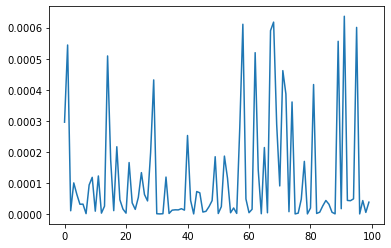

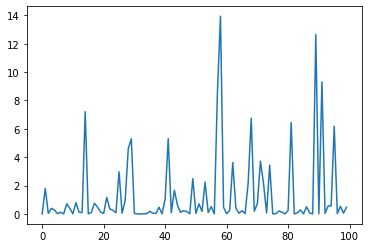

In [32]:
from scipy.linalg import sqrtm, inv,cholesky
vol.predict()
print(cov_nextday["cov"])
print(res2)
print(vol.H_t.shape)
H_t_half_inv = np.zeros((vol.T,vol.N,vol.N))
for tt in range(1,vol.T):
    #print(vol.H_t[tt,:,:])
    H_t_half_inv[tt,:,:] = inv(cholesky(vol.H_t[tt,:,:]))
    

Y_garch = np.zeros((vol.T,vol.N))
for tt in range(vol.T):
    Y_garch[tt,:] = np.random.multivariate_normal(np.array(vol.mean).reshape(vol.N,), vol.H_t[tt,:,:])

asset=0
k=100
plt.figure()
plt.plot(rt[:k,asset]**2)

#z errors
z = np.zeros((vol.T,vol.N))
for tt in range(vol.T):
    z[tt,:] = H_t_half_inv[tt,:,:] @ (rt[tt,:]-np.array(vol.mean).reshape(vol.N,))
plt.figure()
plt.plot(z[:k,asset]**2)

In [114]:
print(vol.H_t[5,:,:])
print(cholesky(vol.H_t[5,:,:]))

[[ 1.71676187e-04 -1.69024331e-05]
 [-1.69024331e-05  8.34428142e-05]]
[[ 0.01310253 -0.00129001]
 [ 0.          0.00904316]]


0.0002986881763728269 0.0166596634996305
8189


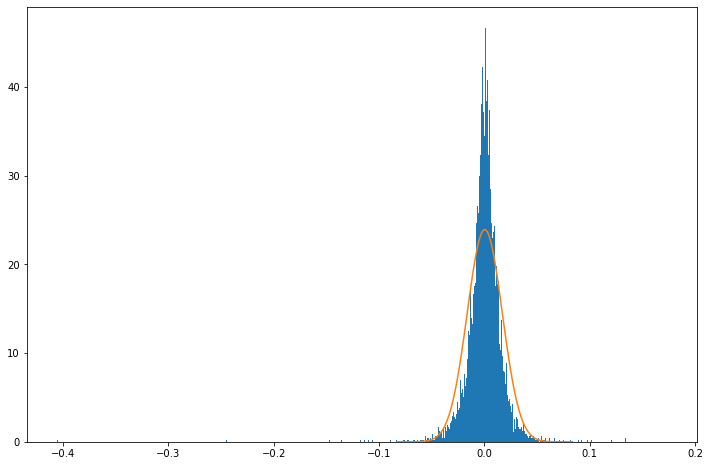

In [103]:
asset=1
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(X[X[:,asset]!=0,asset],density=True,bins=1000)
mu=X[X[:,asset]!=0,asset].mean()
sigma=X[X[:,asset]!=0,asset].std()
plotx = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
ax.plot(plotx, stats.norm.pdf(plotx, mu, sigma))
print(mu,sigma)
print(len(X[X[:,asset]!=0,asset]))

[0.0005 0.0002 0.0001]
[0.0188 0.0183 0.012 ]


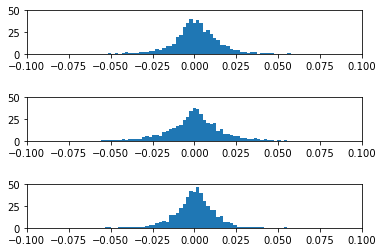

In [108]:
asset=1
#x0 = X[X[:,asset]!=0,asset]
x0=X[:,asset]
groups=3
gr_size = int(np.floor(len(x0)/groups))

Mu = np.zeros(groups)
Sigma = np.zeros(groups)

xmin=-0.1
xmax=0.1

ymax=50

fig, ax_array = plt.subplots(groups)
for i, ax in enumerate(ax_array):
    x0i = x0[i*gr_size:(i+1)*gr_size]
    ax.hist(x0i, density=True,bins=np.linspace(xmin,xmax,100))
   
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((0,ymax))
    Mu[i] = x0i.mean()
    Sigma[i] = x0i.std()

fig.subplots_adjust(hspace=1)
print(np.round(Mu,4))
print(np.round(Sigma,4))

In [23]:
#Select data and VaR constraints

alpha = percentiles#[0.001, 0.01, 0.02]#[0.001, 0.01, 0.1]#[0.001, 0.01, 0.10]
VaR = myVaR+0.001 #[0.03, 0.035, 0.04]#[0.02, 0.03, 0.04]#[-0.05, -0.02, 0.01]

skip = 1 #to speed up the solution process, we only select every "skip"-th row for this example
m,V = portfolioMILP(X[::skip,:], alpha, VaR, max_s = 10, max_weight=0.6) #run MILP for at most max_s seconds

if m.status == OptimizationStatus.OPTIMAL or m.status == OptimizationStatus.FEASIBLE:
    wStar = [m.vars[i].x for i in range(np.shape(X)[1])] #optimal weights
    print(m.status)
    print("The optimal asset allocation is "+str(np.round(wStar,2)))
    print("Portfolio return: "+str(np.round(sum(wStar*X.mean(axis=0))*100,2))+" %")
    print("Portfolio std: "+str(np.round(np.std([sum(wStar*X[i,:]) for i in range(X.shape[0])])*100,2))+" %")

Optimizing over 3 assets using 6964 samples
The model has 7340 vars, 7343 constraints and 36683 nzs
[0.001 0.01 ] [0.034 0.037] OptimizationStatus.FEASIBLE
OptimizationStatus.FEASIBLE
The optimal asset allocation is [0.42 0.33 0.25]
Portfolio return: 6.38 %
Portfolio std: 1.03 %


1


C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


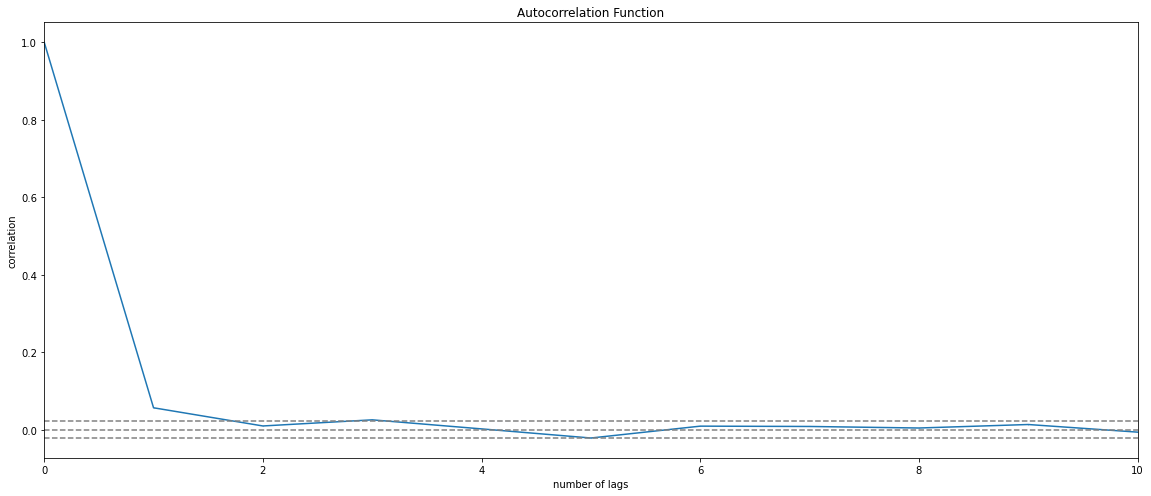

In [199]:
from statsmodels.tsa.stattools import acf, pacf
n_lags=10
print(days)
asset=1
#calling acf function from stattools
#lag_acf = pacf(X[:,0], nlags=n_lags)#, fft=True)
#lag_acf = acf((Y_garch[:,asset]-res.resid[:,asset])**2, nlags=n_lags)#, fft=True)
#lag_acf = acf((res.resid[:,asset])**2, nlags=n_lags)#, fft=True)
lag_acf = acf((z[:,asset]), nlags=n_lags)#, fft=True)
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.plot(lag_acf, marker="o",markersize=0.1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(X)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(X)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

axes = plt.gca()
axes.set_xlim(0,n_lags);
#axes.set_ylim(-0.5,0.5)

#pacf: 1,0
#acf: 0,1

In [300]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
print(X.shape)
print(X[:,0].shape)
cj = coint_johansen(X[:,0],0,2)#stationary since smaller 

#    print(cj.max_eig_stat_crit_vals)
#    print(cj.max_eig_stat)
#    print()
#    print(cj.trace_stat_crit_vals)
#    print(cj.trace_stat)

#    print(cj.eig)


def joh_output(cj_res):
    output = pd.DataFrame([cj_res.lr2,cj_res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",cj_res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",cj_res.cvt,'\n')
joh_output(cj)

(8202, 2)
(8202,)


IndexError: tuple index out of range

In [305]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        
adfuller_test(X[:,0])
adfuller_test(X[:,1])
adfuller_test(res.resid[:,0])
adfuller_test(res.resid[:,1])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -22.6337
 No. Lags Chosen       = 16
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -45.0338
 No. Lags Chosen       = 3
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statist

,0,1
count,8202.000000,8202.000000
mean,0.000008,0.000012
std,0.011864,0.015176
min,-0.233265,-0.277737
25%,-0.004800,-0.006969
50%,0.000400,0.000090
75%,0.005514,0.007303
max,0.098950,0.139251


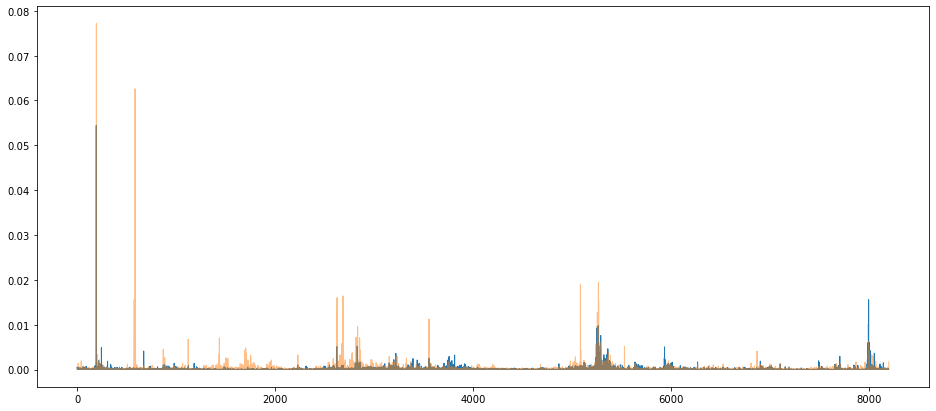

In [336]:

plt.figure(figsize=(16, 7))
plt.plot(res.resid[:,0]**2,linewidth=1)
plt.plot(res.resid[:,1]**2,linewidth=1,alpha=0.5)
res_df = pd.DataFrame(res.resid)
res_df.describe()

[ 0.0002 -0.      0.0004  0.0004 -0.0008  0.0001 -0.0007  0.0002 -0.
  0.0002]
[0.0134 0.0082 0.0063 0.0129 0.0139 0.0068 0.0187 0.0105 0.0081 0.014 ]


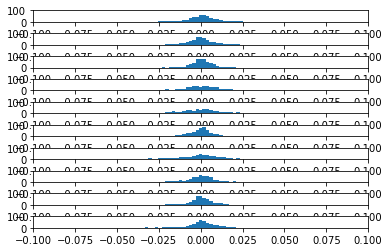

In [371]:
asset=0
x0=res.resid[:,asset]
groups=10
gr_size = int(np.floor(len(x0)/groups))

Mu = np.zeros(groups)
Sigma = np.zeros(groups)

xmin=-0.1
xmax=0.1

ymax=100

fig, ax_array = plt.subplots(groups)
for i, ax in enumerate(ax_array):
    x0i = x0[i*gr_size:(i+1)*gr_size]
    ax.hist(x0i, density=True,bins=np.linspace(xmin,xmax,100))
   
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((0,ymax))
    Mu[i] = x0i.mean()
    Sigma[i] = x0i.std()

fig.subplots_adjust(hspace=1)
print(np.round(Mu,4))
print(np.round(Sigma,4))

,0,1
0,1.000000,0.243487
1,0.243487,1.000000


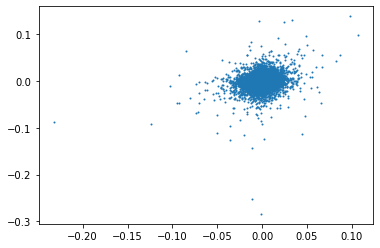

In [351]:
plt.scatter(x=res.resid[:,0],y=res.resid[:,1], s=1)
res_df.corr()

In [355]:
a=[1,2,3]
a[0:1]

[1]

In [170]:
#Univariate KS tests to check if distributions are identical

from scipy import stats
#data = np.random.normal(loc=0.0, scale=1.0, size=(8202,2))
data = z
#data = res.resid
#data= X
n,d = z.shape
print(n,d)
asset=0
groups_max = 10

ks_p = np.zeros((groups_max-1,groups_max-1)) #min is 2 groups, hence -1

for gg in range(groups_max-1): #gg is index, at least 2
    n_g = gg+2
    gr_size = int(np.floor(len(data)/n_g))
    for ii in range(gg+1):
        d0 = data[gr_size*ii:gr_size*(ii+1)+1,asset]
        d1 = data[gr_size*(ii+1):gr_size*(ii+2)+1,asset]
        _, ks_p[gg,ii] = stats.ks_2samp(d0,d1)

print((ks_p.round(4) >= 0.01).sum()/np.sum(np.arange(groups_max)))

8202 2
0.37777777777777777


In [147]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [34]:
import statsmodels.api as sm

myp=1
myq=2
mod = sm.tsa.VARMAX(X, order=(myp,myq))
res_varma = mod.fit(maxiter=100, disp=True)
print(res_varma.summary())

C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:           ['y1', 'y2']   No. Observations:                 8202
Model:                     VARMA(1,2)   Log Likelihood               47632.478
                          + intercept   AIC                         -95230.955
Date:                Mon, 22 Feb 2021   BIC                         -95111.749
Time:                        09:36:51   HQIC                        -95190.204
Sample:                             0                                         
                               - 8202                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.00, 0.01   Jarque-Bera (JB):   247421.33, 374928.07
Prob(Q):                        0.97, 0.94   Prob(JB):                     0.00, 0.00
Heteroskedasticity (H):         1.25, 0.39   Skew:                       -1.38, -1.58
Prob(H) (two-sided):           

1641
6561
(8202, 2)


<AxesSubplot:>

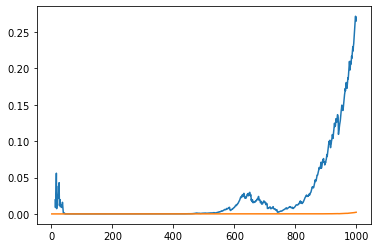

In [417]:
res.aic
print(n_test)
print(n_train)

asset = 0
#ljungbox = res.test_serial_correlation('ljungbox')
#print(ljungbox.shape)
#sm.stats.acorr_ljungbox(res.resid[:,0], lags=[10], return_df=True)
#sm.stats.acorr_ljungbox(res.resid[:,1], lags=[10], return_df=True)
np.random.seed(42)
print(res.resid.shape)
Xrand= np.random.rand(1000)
Xrandnot = np.ones(1000)+np.linspace(-1,1,1000)
df_lb = sm.stats.acorr_ljungbox(res.resid[:,asset], lags=list(range(1,1000)), model_df=myp+myq, return_df=True)
df_lb["lb_pvalue"].plot()

df_lb_base = sm.stats.acorr_ljungbox(X[:,asset], lags=list(range(1,1000)), return_df=True)
df_lb_base["lb_pvalue"].plot()

In [184]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
n,d = X.shape
n_train = len(X_train)
n_test = len(X_test)
max_p = 5
max_q = 5

AIC_store = np.zeros((max_p+1,max_q+1))
BIC_store = np.zeros((max_p+1,max_q+1))
TrainRMSE = np.zeros((max_p+1,max_q+1))
TestRMSE = np.zeros((max_p+1,max_q+1))

for pp in range(max_p+1):
    for qq in range(max_q+1):
        if pp==0 and qq==0:
            continue #no (0,0) model trained
        mod = sm.tsa.VARMAX(X_train, order=(pp,qq))
        res = mod.fit(maxiter=100, disp=False)
        AIC_store[pp,qq] = res.aic
        BIC_store[pp,qq] = res.bic
        
        #predictions
        Y_train = res.predict()
        res = res.extend(X_test)
        Y_test = res.predict(start=n_train, end=n_train+n_test-1) #end index is inluded too here
        
        #errors
        TrainRMSE[pp,qq] = np.sqrt(mse(Y_train,X_train))
        TestRMSE[pp,qq] = np.sqrt(mse(Y_test,X_test))

#print(AIC_store)
#print(TestRMSE)
print(np.unravel_index(np.argmin(AIC_store),np.shape(AIC_store)))
TestRMSE[0,0]=np.inf
print(np.unravel_index(np.argmin(TestRMSE),np.shape(TestRMSE)))

C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VAR

C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\worc3920\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationW

(0, 5)
(0, 2)


In [ ]:
#Next steps
#estimate best model
#verify independence of errors (Ljung-Box test? Engle ARCH test?)
#verify identical distribution (Kolmogorov-Smirnov test?)
#

1


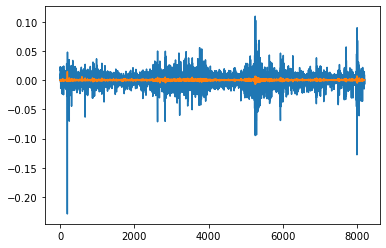

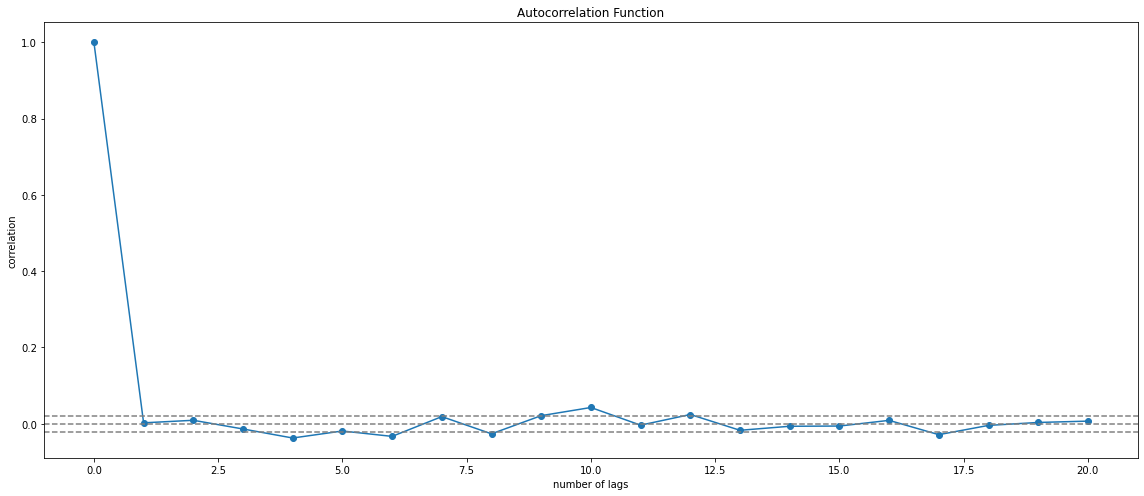

In [194]:
Y = res.predict()
plt.plot(X[:,0])
plt.plot(Y[:,0])
#plt.plot((Y-X)[:,1],alpha=1)
#plt.plot((Y-X)[:,0],alpha=0.3)
n_lags=20
print(days)
#calling acf function from stattools
#lag_acf = pacf((Y-X)[:,1], nlags=n_lags)#, fft=True)
lag_acf = pacf(res.resid[:,0], nlags=n_lags)#, fft=True)
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(X)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(X)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()
#pacf [4,6,9,10], [3,4]##seasonal 26,44,64,140 (delta: 18,20,68), 17,138
#acf [4,6,9,10], [3,4]##seasonal 26,44,64,140 (delta: 18,20,68), 17,138

[-0.0002  0.0004 -0.0002]
[0.0099 0.014  0.0111]


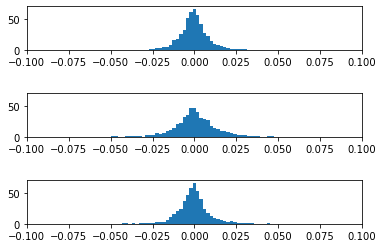

In [341]:
asset = 0
#x0 = X[X[:,asset]!=0,asset]
x0=(Y-X)[:,asset]
groups=3
gr_size = int(np.floor(len(x0)/groups))

Mu = np.zeros(groups)
Sigma = np.zeros(groups)

fig, ax_array = plt.subplots(groups)
for i, ax in enumerate(ax_array):
    x0i = x0[i*gr_size:(i+1)*gr_size]
    ax.hist(x0i, density=True,bins=np.linspace(-0.1,0.1,100))
   
    ax.set_xlim((-0.1,0.1))
    ax.set_ylim((0,70))
    Mu[i] = x0i.mean()
    Sigma[i] = x0i.std()

fig.subplots_adjust(hspace=1)
print(np.round(Mu,4))
print(np.round(Sigma,4))

In [311]:
############TIME SERIES FUN STARTS HERE ###################
#VARIMA p,i,q where lags are shifted by the investment horizon

#from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import linear_model
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

def lagVAR(X_in, p=3, lag=int(days), alpha=1):
    #difference data
    n,d=np.shape(X_in)
    #print(n,d)
    #print(lag)
    
    #differencing updates X
    #for dd in range(d):
    #    X_in[dd:-1,:] = X_in[dd+1:,:]-X_in[dd:-1,:]
    #    X_in=X_in[:-1,:]
    #n -= i
    
    X=np.zeros((n-lag-p,d,p)) #data
    Y=np.zeros((n-lag-p,d)) #predictions
    for tt in range(n-lag-p):
        Y[tt,:] = X_in[tt+lag+p,:]
        X[tt,:,:] = X_in[tt:tt+p,:].T
      
    X = X.reshape((n-lag-p,d*p))
    #print(X.shape)
    #clf = MultiOutputRegressor(Lasso(max_iter=10**5, alpha=alpha))
    #clf = MultiOutputRegressor(Ridge(random_state=42,alpha=alpha))
    clf = Ridge(random_state=42,alpha=alpha)
    clf.fit(X,Y)
    #clf = linear_model.Lasso(alpha=alpha)
    #clf.fit(X,Y)
    return clf,X,Y


In [471]:
print(len(X))
lag=days

17462


In [477]:
p0=1
alpha0=100
clf,Xtrain,Ytrain = lagVAR(X_in = X[:10000,:], p=p0, alpha=alpha0)
clf2,Xtest,Ytest = lagVAR(X_in = X[10000-days+1:,:],  p=p0)
clf_all,X_all,Y_all = lagVAR(X_in=X,p=p0, alpha=alpha0)

0.258048650247779
-1.2468294867104444


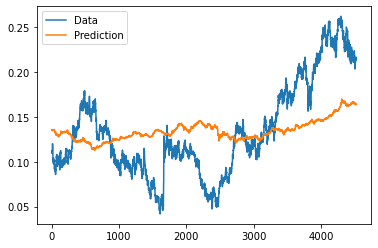

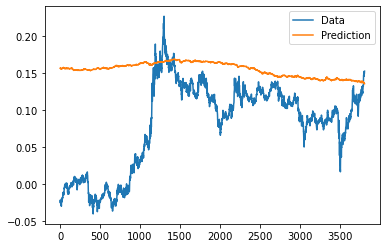

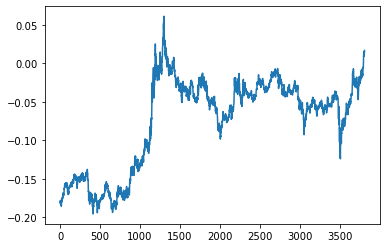

In [478]:
clf.get_params(deep=True)
print(clf.score(Xtrain,Ytrain))
print(clf.score(Xtest,Ytest))
#clf.predict(Xout[0,:].reshape(1,-1))

#Train
plt.plot(Ytrain[:,0])
plt.plot(clf.predict(Xtrain)[:,0])
plt.legend(["Data","Prediction"])

#Test
plt.figure()
plt.plot(Ytest[:,0])
plt.plot(clf.predict(Xtest)[:,0])
plt.legend(["Data","Prediction"])

#Residuals
plt.figure()
plt.plot(Ytest[:,0]-clf.predict(Xtest)[:,0])

[[ 0.04777354 -0.0835358 ]
 [-0.01344135  0.07654586]]
(17462, 2)
11986
[0.08373094147285123, 0.04405339861710764]


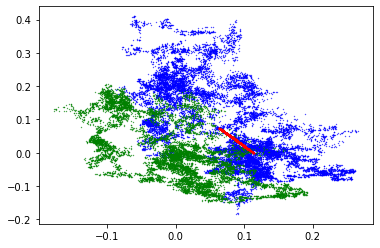

In [493]:
print(clf.coef_)
#Plot Empirical distribution and error distribution'
print(X.shape)
plt.scatter(x=X[:,0],y=X[:,1],c='b',s=0.1)

residual = Y_all - clf_all.predict(X_all)
n_res=len(residual)
print(n_res)
plt.scatter(x=residual[:,0],y=residual[:,1],c='g', s=0.1)
plt.scatter(x=clf_all.predict(X_all)[:,0], y=clf_all.predict(X_all)[:,1],c='r', s=0.1)

print([Y_all[:,i].mean() for i in range(2)])

-1.363464285206266e-16 0.08081789264974233
0.07788313757796106 0.100861437823029


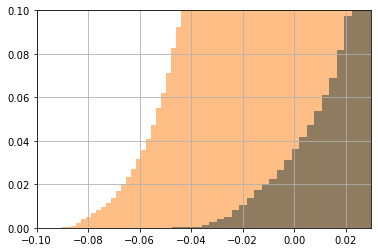

In [515]:
n,d=X.shape
ax = plt.hist(X.sum(axis=1)/d,bins=100,cumulative=True,density=True)
ax = plt.hist(residual.sum(axis=1)/d,bins=100,alpha=0.5,cumulative=True,density=True)
print(residual.mean(),residual.std())
print(X.mean(),X.std())


axes = plt.gca()
axes.set_ylim(0,0.1)
axes.set_xlim(-0.1,0.03)
plt.grid(True)

In [405]:
len(X)
from sklearn.base import BaseEstimator, RegressorMixin

class myAverage(BaseEstimator, RegressorMixin):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        n,d=X.shape
        p=100
        lag=15*365
        y=np.zeros((n-p-lag,d))
        for i in range(n-p-lag):
            for dd in range(d):
                y[i,dd] = sum([X[j,dd] for j in range(i,i+p)])/p
        return y

In [354]:
n,d=X.shape
print(X.shape)
print(15*365)

(6964, 3)
5475


In [373]:
print([i for i in range(1,2)])

[1]


In [470]:
p=100
est2=myAverage()
Y2 = est2.predict(X)
Y2.shape
print(days==15*365)
print(6000-days+1)
print(n-days-p)
print(n)
print(est2.score(X[6000-days-p:,:],X[6000:,:]))

#Observation
plt.plot(X[6000:,0],'b', linewidth=2)
#Prediction
plt.plot(est2.predict(X[6000-days-p:,:])[:,0], 'r', linewidth=2)

False
4176
5039
6964


ValueError: Found input variables with inconsistent numbers of samples: [11462, 7812]

In [475]:
alphas = np.linspace(0,100,20)
ps=np.linspace(1,100,10)
scores = np.zeros((len(alphas),len(ps)))
for aa in range(len(alphas)):
    for pp in range(len(ps)):
        clf,Xtrain,Ytrain = lagVAR(X_in = X[:10000,:], p=int(ps[pp]), alpha=alphas[aa])
        clf2,Xtest,Ytest = lagVAR(X_in = X[10000-days+1:,:],  p=int(ps[pp]), alpha=1)
        scores[aa,pp] = clf.score(Xtest,Ytest)

print(np.unravel_index(np.argmax(scores),np.shape(scores)))
print(np.max(scores))
#print(scores)

(19, 0)
-1.2468294867104444
[[-2.88147595 -2.87508026 -2.87532967 -2.8884138  -2.90131351 -2.912252
  -2.92143253 -2.92806928 -2.93825725 -2.95577793]
 [-2.45976531 -2.84332112 -2.86995571 -2.88175582 -2.89394632 -2.90792652
  -2.92134131 -2.93281256 -2.94074972 -2.94983635]
 [-2.2273088  -2.79793647 -2.85039761 -2.87174736 -2.88705026 -2.90217659
  -2.91684937 -2.9300652  -2.94026712 -2.94981173]
 [-2.06518347 -2.75482404 -2.82822769 -2.85897201 -2.87850539 -2.89553094
  -2.91143603 -2.9259401  -2.9378072  -2.9483425 ]
 [-1.94040797 -2.71452711 -2.8056373  -2.84492715 -2.86890188 -2.88819951
  -2.90546132 -2.9211274  -2.93435704 -2.94591819]
 [-1.83934883 -2.67687586 -2.78331349 -2.83031675 -2.85864071 -2.8803675
  -2.89908789 -2.91588279 -2.930312   -2.9428591 ]
 [-1.75493774 -2.64160997 -2.76151258 -2.81550455 -2.84798113 -2.87217735
  -2.89241875 -2.91033643 -2.92586977 -2.93935602]
 [-1.6829528  -2.60847611 -2.74033214 -2.80069179 -2.83709364 -2.86373616
  -2.88552806 -2.90456789 

In [476]:
print(alphas[19])
print(ps[0])

100.0
1.0


In [216]:
for i in range(3):
    print(abs(np.round(clf.estimators_[i].coef_.reshape((3,10)),1)) > 0.1)
    print()

AttributeError: 'Ridge' object has no attribute 'estimators_'

In [134]:
np.min(X)

-0.029604947994605113

We can now visualize the result to see how the MILP algorithm has segmented the distribution according to the VaR constraints:

In [123]:
def plotDistribution(X, m, V, alpha, i0=0, i1=1, names=["SP500","HSI"], cmap_str = 'gist_rainbow', markersize=5, fig_size=(8,6)):
    x1=X[:,i0]
    x2=X[:,i1]
    
    n_x=len(x1)
    d=2
    n_alpha=len(alpha)
    dropped=[[] for i in range(n_alpha)]
    kept=list(range(n_x))

    for aa in range(n_alpha):
        for vv in range(len(V[aa])):
            if m.var_by_name(f'z_{aa}_{vv}').x == 0:
                dropped[aa].append(V[aa][vv])

    fig=plt.figure(figsize = fig_size, dpi = 100)
    cmap=plt.cm.get_cmap(cmap_str,n_alpha)
    
    plt.scatter(x1[kept],x2[kept],s=markersize,c='grey')
    for aa in reversed(range(n_alpha)):
        plt.scatter(x1[dropped[aa]],x2[dropped[aa]],s=markersize,color=cmap(aa/(n_alpha)))
    
    plt.grid(True)
    plt.xlabel(names[0])
    plt.ylabel(names[1])
    plt.title('Annual returns')

    plt.gca().set_aspect('equal', adjustable='box')
    return x1, x2, cmap

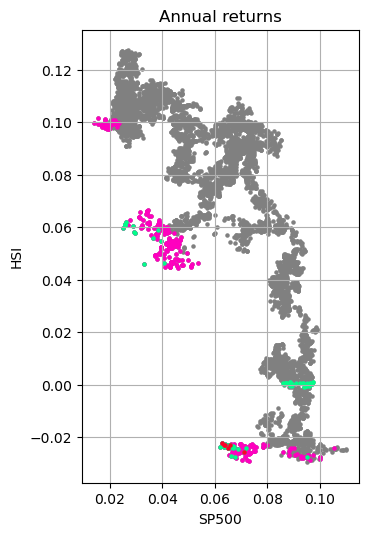

In [144]:
x1, x2, cmap = plotDistribution(X[::skip,:], m, V, alpha, markersize=5)

In [344]:
def getEmpiricalDensity(data):
    n,d=np.matrix(data).shape
    df2=pd.DataFrame()
    for i in range(d):
        df2[f"value_{i}"]=data[:,i]
        # Frequency
        df2[f"frequency_{i}"] = 1

        # PDF
        df2[f'pdf_{i}'] = df2[f'frequency_{i}'] / sum(df2[f'frequency_{i}'])

        # CDF
        df2 = df2.sort_values(f"value_{i}")
        df2[f'cdf_{i}'] = df2[f'pdf_{i}'].cumsum()
        df2 = df2.reset_index()

        # Plot
    fig, ax = plt.subplots()
    for i in range(d):
        df2 = df2.sort_values(f"value_{i}")
        df2.plot(ax = ax, x = f'value_{i}', y = f'cdf_{i}', xlim=(-0.1,0.3), grid = True,legend=False)

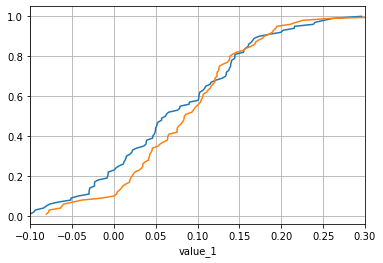

In [345]:
getEmpiricalDensity(pred_returns)

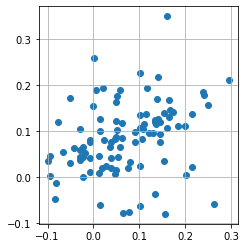

In [286]:
plt.scatter(x=pred_returns[:,0],y=pred_returns[:,1])
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

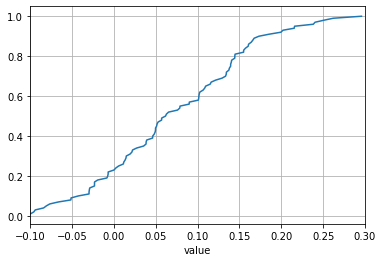

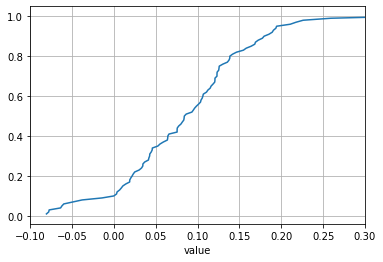

In [283]:
ax = getEmpiricalDensity(pred_returns[:,0]);
getEmpiricalDensity(pred_returns[:,1]);


[[ 0.          0.        ]
 [ 1.34354562 -0.54515641]
 [ 0.19103245 -0.26117327]
 ...
 [-0.45695727  1.12173332]
 [-1.183361    0.77297761]
 [-3.29999447  7.04532457]]


(-5.0, 5.0)

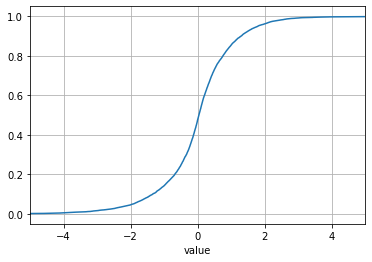

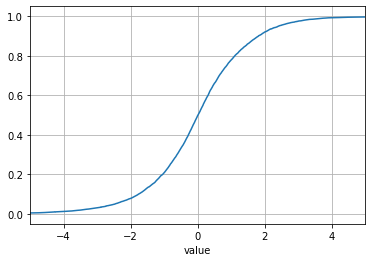

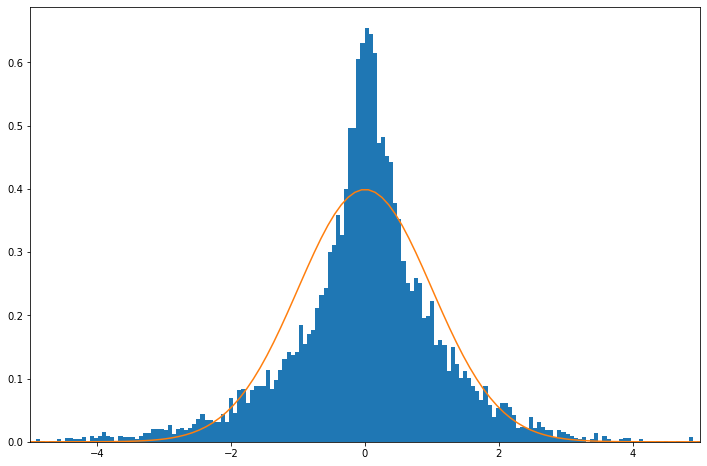

In [220]:
print(z)
getEmpiricalDensity(z[:,0])
getEmpiricalDensity(z[:,1])

plt.figure(figsize = (12,8))
plt.hist(z[:,0],density=True, bins=1000)
mu = 0
variance = 1
sigma = np.sqrt(variance)
x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
axes = plt.gca()
axes.set_xlim(-5,5)

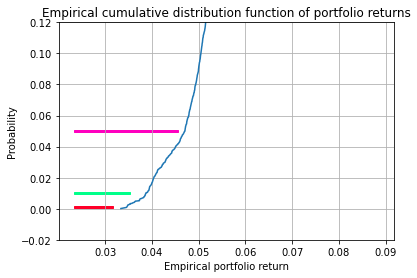

In [145]:
Xskip=X[::skip,:]
R = np.sort([sum(wStar*Xskip[i,:]) for i in range(len(Xskip))])
add_length=0.01
getEmpiricalDensity(pd.Series(R))
for i in range(len(VaR)):
    plt.arrow(x=np.min(R)-add_length, dx=VaR[i]-np.min(R)+add_length, y=alpha[i], dy=0, color=cmap(i/len(alpha)), length_includes_head = True,
                   head_width=0,head_length=0)
plt.xlabel('Empirical portfolio return')
plt.ylabel('Probability')
plt.title('Empirical cumulative distribution function of portfolio returns')

axes = plt.gca()
axes.set_ylim(-0.02,0.12)
plt.show()

In [ ]:
########## Sampling prediction

